# Lollipop plot analysis

## Requires having run vcf2maf on the output of vk clean with a command like this:
- perl vcf2maf.pl --input-vcf variants.vcf --output-maf variants.maf --ref-fasta /path/to/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --cache-version 93 --species homo_sapiens --ncbi-build GRCh37 --retain-info DP,NS

In [ ]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [ ]:
import os
from rpy2.robjects import pandas2ri, r, globalenv
import pandas as pd
from varseek.utils import download_box_url  # for functions used in both varseek and here
# from RLSRWP_2025 import ...  # for functions only used here

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

### File path definitions and imports

In [ ]:
number_of_genes = 5
sorting_method = "number_of_distinct_variants"  # "total_counts" or "number_of_distinct_variants"

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out_fig1")
# maf_path = os.path.join(vk_count_out_dir, "variants.maf")  #!!! uncomment
maf_path = "/Users/joeyrich/Desktop/local/varseek/variants.maf"  #!!! erase

out_dir = os.path.join(vk_count_out_dir, "analysis", "lollipop_plots")

In [ ]:
if not os.path.exists(maf_path):
    maf_url = ""  #!!!
    download_box_url(maf_url, output_file_name=maf_path)

In [7]:
%load_ext rpy2.ipython

In [8]:
# Activate the automatic conversion between pandas and R objects
pandas2ri.activate()

In [9]:
%%R
library(maftools)

In [10]:
# %%R -i maf_path
# cosmic_maf = read.maf(maf = maf_path)

# lollipopPlot(
#   maf = cosmic_maf,
#   gene = 'MT-CO1',
#   AACol = "HGVSp_Short",
#   showMutationRate = TRUE,
#   # labelPos = c(687, 678),
# )

### Load in data

In [13]:
# Load the MAF file as a DataFrame
df = pd.read_csv(maf_path, sep='\t', comment='#', low_memory=False)

# Select the desired columns
selected_columns = ["Hugo_Symbol", "vcf_id", "Protein_position", "Variant_Classification", "DP", "NS"]
df = df[selected_columns]
df['Protein_position'] = df['Protein_position'].str.split('/').str[0].str.split('-').str[0].astype(int)
df['DP'] = df['DP'].astype(int)
df.rename(columns={"DP": "count", "Protein_position": "pos"}, inplace=True)

# Display the first few rows
df.head()

,Hugo_Symbol,vcf_id,pos,Variant_Classification,count,NS
0,WASH4P,ENST00000326592:c.1235C>T,192,Silent,2,1
1,MT-CO1,ENST00000361624:c.924T>C,308,Silent,2,1
2,MT-CO1,ENST00000361624:c.1439G>A,480,Missense_Mutation,2,1
3,MT-CO1,ENST00000361624:c.922G>A,308,Missense_Mutation,8,1
4,MT-CO1,ENST00000361624:c.1477G>A,493,Missense_Mutation,3,1


In [30]:
# Sort genes in descending order
if sorting_method == "total_counts":
    # sort based on total counts
    sorted_genes = df.groupby("Hugo_Symbol")["count"].sum().sort_values(ascending=False)
    print("Gene: Counts")
elif sorting_method == "number_of_distinct_variants":
    # sort based on number of distinct variants
    sorted_genes = df["Hugo_Symbol"].value_counts()
    print("Gene: Number of Distinct Variants")

sorted_genes_dict = sorted_genes.to_dict()
sorted_genes_dict

Gene: Number of Distinct Variants


{'MT-CO1': 19,
 'MT-ATP6': 16,
 'MT-ND2': 10,
 'NOC2L': 2,
 'WASH4P': 1,
 'MT-ND1': 1,
 'MT-ND6': 1}

In [ ]:
os.makedirs(out_dir, exist_ok=True)

# Loop through each gene in sorted order
for i, gene in enumerate(sorted_genes.index[:number_of_genes]):
    # Create a temporary DataFrame for the current gene
    temp = df[df['Hugo_Symbol'] == gene].copy()
    
    # Select only pos and count columns
    my_data = temp[['pos', 'count']]

    plot_path = os.path.join(out_dir, f"lollipop_plot_{i+1}_{gene}.pdf")
    
    # Pass the data and gene to the R global environment
    globalenv['my_data'] = my_data
    globalenv['gene'] = gene
    globalenv['plot_path'] = plot_path

    # Execute the multi-line R code: open a PDF, plot, and close the PDF device
    r_code = '''
    pdf(plot_path)
    lollipopPlot(data = my_data, gene = gene)
    dev.off()
    '''
    try:
        r(r_code)
    except Exception as e:
        print(f"Error generating plot for {gene}: {e}")
        continue
    print(f"Plot saved for {gene} at {plot_path}")


     HGNC refseq.ID protein.ID aa.length
1: DNMT3A NM_022552  NP_072046       912
2: DNMT3A NM_153759  NP_715640       723
3: DNMT3A NM_175629  NP_783328       912


3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.
Using longer transcript NM_022552 for now.


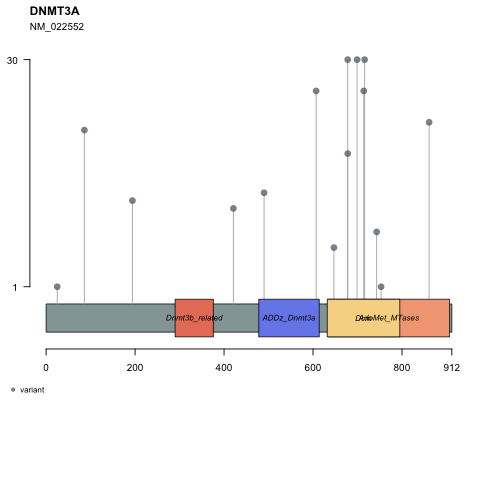

In [ ]:
# %%R
# my_data = data.frame(pos = sample.int(912, 15, replace = TRUE), count = sample.int(30, 15, replace = TRUE))
# head(my_data)
# # pdf("lollipop_plot.pdf")
# lollipopPlot(data = my_data, gene = "DNMT3A")
# # dev.off()